In [1]:
import json
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from pathlib import Path
import requests
import scipy.stats as st
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, inspect, text
from sqlalchemy.orm import Session


In [2]:
username = "postgres"
password = "postgres"
host = "localhost"
port = "5432"
database = "MSUDA-project-ETL-crowdfunding"

connection_string = f"postgresql://{username}:{password}@{host}:{port}/{database}"

In [3]:
engine = create_engine(connection_string)

In [4]:
try:
    with engine.connect() as test_connection:
        print(f"Connected! {test_connection}")
except Exception as e:
    print(f"Error: {e}")

Connected! <sqlalchemy.engine.base.Connection object at 0x1276f0950>


In [5]:
query = "SELECT * FROM campaign;"
campaign_df = pd.read_sql(query, engine)

campaign_df.head()

,cf_id,contact_id,company_name,description,goal,pledged,outcome,backers_count,country,currency,launch_date,end_date,category_id,subcategory_id,last_updated
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13,2021-03-01,category1,subcategory1,2025-01-20 13:27:50.457731
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400.0,14560.0,successful,158,US,USD,2021-01-25,2021-05-25,category2,subcategory2,2025-01-20 13:27:50.457731
2,1812,4187,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure,108400.0,142523.0,successful,1425,AU,AUD,2020-12-17,2021-12-30,category3,subcategory3,2025-01-20 13:27:50.457731
3,2156,4941,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration,4200.0,2477.0,failed,24,US,USD,2021-10-21,2022-01-17,category2,subcategory2,2025-01-20 13:27:50.457731
4,1365,2199,Larson-Little,Proactive foreground core,7600.0,5265.0,failed,53,US,USD,2020-12-21,2021-08-23,category4,subcategory4,2025-01-20 13:27:50.457731


In [6]:
query = "SELECT * FROM contacts;"
contacts_df = pd.read_sql(query, engine)

contacts_df.head()

,contact_id,first_name,last_name,email,last_updated
0,4661,cecilia,velasco,cecilia.velasco@rodrigues.fr,2025-01-20 13:27:29.481314
1,3765,mariana,ellis,mariana.ellis@rossi.org,2025-01-20 13:27:29.481314
2,4187,sofie,woods,sofie.woods@riviere.com,2025-01-20 13:27:29.481314
3,4941,jeanette,iannotti,jeanette.iannotti@yahoo.com,2025-01-20 13:27:29.481314
4,2199,samuel,sorgatz,samuel.sorgatz@gmail.com,2025-01-20 13:27:29.481314


In [7]:
# Query the tables

df_table1 = pd.read_sql("SELECT * FROM campaign;", engine)
df_table2 = pd.read_sql("SELECT category_id, category FROM category;", engine)

# Merge Tables

df_merged = pd.merge(df_table1, df_table2, on="category_id", suffixes=("", "_new"))
df_merged["category_id"] = df_merged["category"]
df_merged.drop(columns=["category_id", "subcategory_id", "cf_id", "contact_id", "launch_date", "end_date", "last_updated"], inplace=True)
df_merged.head()

,company_name,description,goal,pledged,outcome,backers_count,country,currency,category
0,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,food
1,Odom Inc,Managed bottom-line architecture,1400.0,14560.0,successful,158,US,USD,music
2,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure,108400.0,142523.0,successful,1425,AU,AUD,technology
3,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration,4200.0,2477.0,failed,24,US,USD,music
4,Larson-Little,Proactive foreground core,7600.0,5265.0,failed,53,US,USD,theater


In [8]:
# Query 1 

query = "SELECT cf_id, company_name, description, backers_count, pledged, outcome, country FROM campaign WHERE outcome = 'successful' ORDER BY backers_count DESC;"

query1_df = pd.read_sql(query, engine)
query1_df.head()

,cf_id,company_name,description,backers_count,pledged,outcome,country
0,1659,Fox-Williams,Profound system-worthy functionalities,7295,196960.0,successful,US
1,211,Avila-Nelson,Up-sized intermediate website,6465,168095.0,successful,US
2,1875,"Hughes, Mendez and Patterson",Stand-alone multi-state data-warehouse,6406,179356.0,successful,US
3,305,Padilla-Porter,Innovative exuding matrix,6286,182302.0,successful,US
4,2301,Schmitt-Mendoza,Profound explicit paradigm,6212,167717.0,successful,US


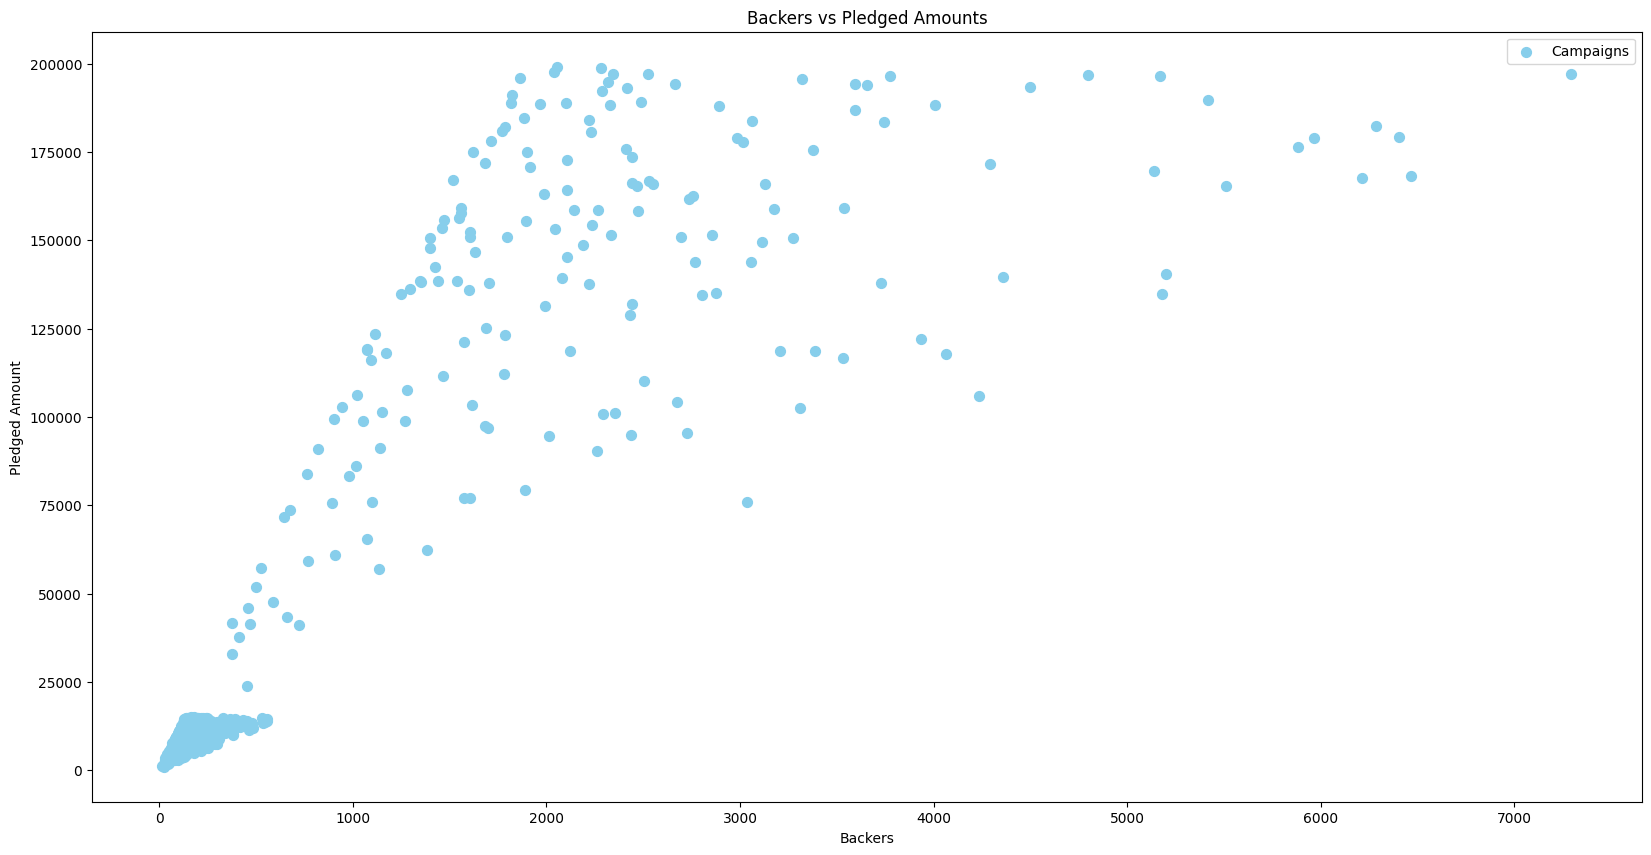

In [9]:
# Create scatter plot

plt.figure(figsize=(20, 10))
plt.scatter(query1_df["backers_count"], query1_df["pledged"], color="skyblue", s=50, label="Campaigns")

# Add labels and title
plt.xlabel("Backers")
plt.ylabel("Pledged Amount")
plt.title("Backers vs Pledged Amounts")
plt.legend()

# Show the chart
plt.show()

In [10]:
# Query 1.5

query = "SELECT cf_id, company_name, description, backers_count, pledged, outcome, country FROM campaign WHERE outcome = 'failed' ORDER BY backers_count DESC;"

query15_df = pd.read_sql(query, engine)
query15_df.head()

,cf_id,company_name,description,backers_count,pledged,outcome,country
0,1281,Rosario-Smith,Enterprise-wide intermediate portal,6080,188480.0,failed,CA
1,2171,"Whitehead, Bell and Hughes",Multi-tiered radical definition,5681,176112.0,failed,US
2,2201,Davis and Sons,Innovative human-resource migration,5497,159405.0,failed,US
3,507,"Ferguson, Murphy and Bright",Multi-lateral heuristic throughput,4697,178483.0,failed,US
4,2837,Kelly-Colon,Stand-alone grid-enabled leverage,4428,110689.0,failed,AU


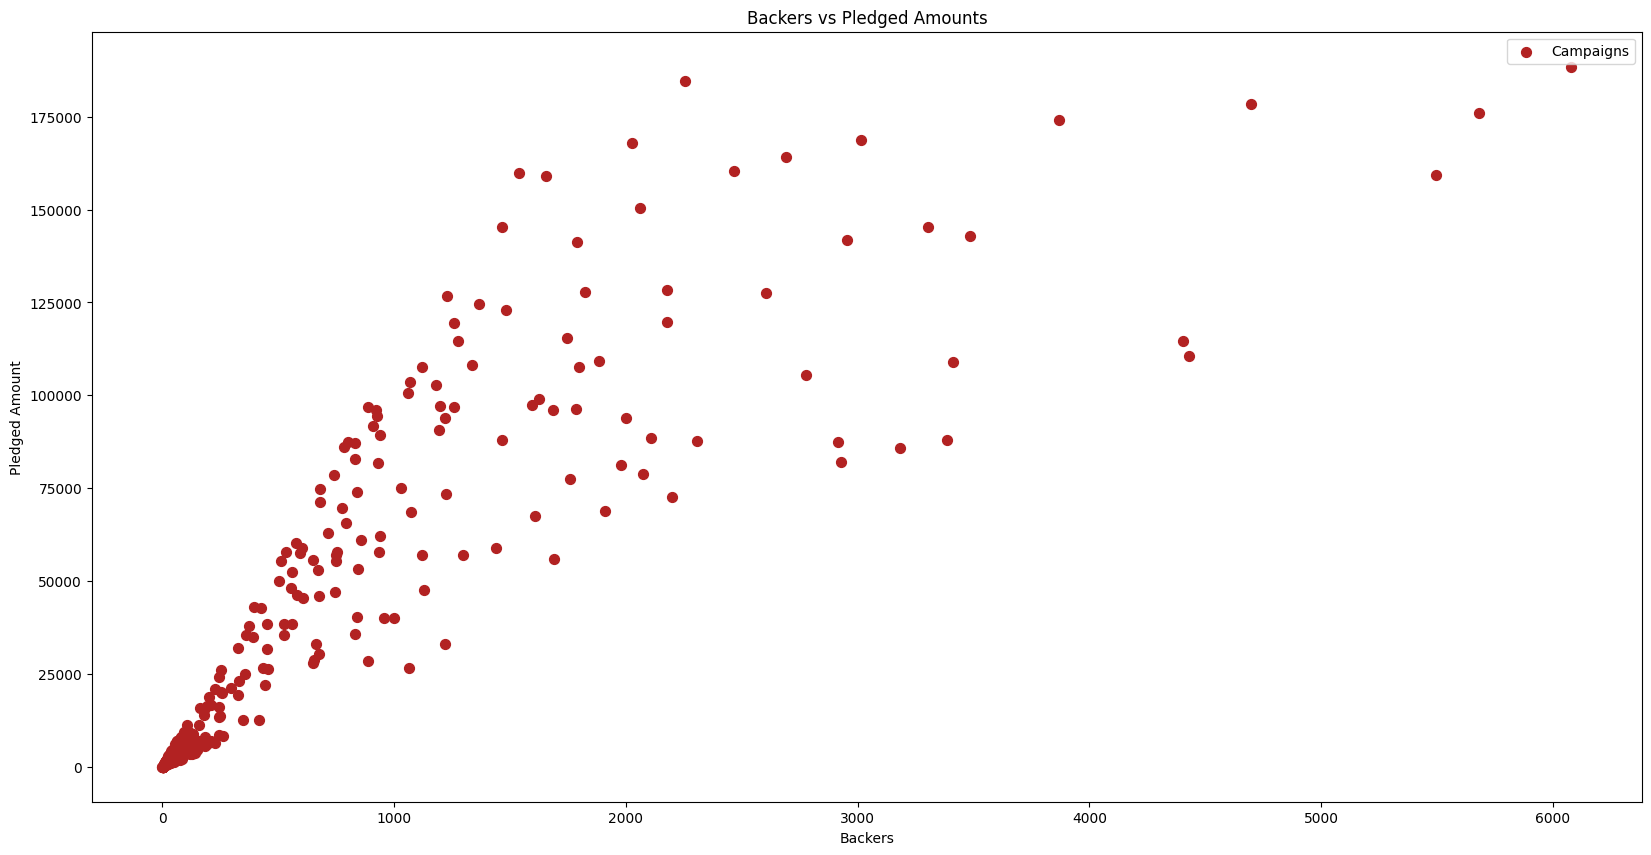

In [11]:
# Create scatter plot

plt.figure(figsize=(20, 10))
plt.scatter(query15_df["backers_count"], query15_df["pledged"], color="firebrick", s=50, label="Campaigns")

# Add labels and title
plt.xlabel("Backers")
plt.ylabel("Pledged Amount")
plt.title("Backers vs Pledged Amounts")
plt.legend()

# Show the chart
plt.show()

In [12]:
# Query 2

query = "SELECT description, pledged, outcome, country FROM campaign WHERE outcome = 'successful' ORDER BY country DESC"

query2_df = pd.read_sql(query, engine)
query2_df

,description,pledged,outcome,country
0,Vision-oriented scalable definition,153216.0,successful,US
1,Reduced next generation info-mediaries,6358.0,successful,US
2,Programmable leadingedge contingency,14725.0,successful,US
3,Multi-layered global groupware,11174.0,successful,US
4,Switchable methodical superstructure,182036.0,successful,US
...,...,...,...,...
560,Digitized local info-mediaries,77012.0,successful,AU
561,Optional tangible pricing structure,5107.0,successful,AU
562,Customer-focused client-server service-desk,193413.0,successful,AU
563,Exclusive fresh-thinking model,13250.0,successful,AU


In [13]:
# Query 3

query = "SELECT cf_id, company_name, description, backers_count, pledged, outcome FROM campaign WHERE outcome = 'successful' ORDER BY backers_count DESC;"

query3_df = pd.read_sql(query, engine)
query3_df.head()

,cf_id,company_name,description,backers_count,pledged,outcome
0,1659,Fox-Williams,Profound system-worthy functionalities,7295,196960.0,successful
1,211,Avila-Nelson,Up-sized intermediate website,6465,168095.0,successful
2,1875,"Hughes, Mendez and Patterson",Stand-alone multi-state data-warehouse,6406,179356.0,successful
3,305,Padilla-Porter,Innovative exuding matrix,6286,182302.0,successful
4,2301,Schmitt-Mendoza,Profound explicit paradigm,6212,167717.0,successful


In [14]:
# Query 4

query = "SELECT country, COUNT(*) AS successful_campaigns FROM campaign WHERE outcome = 'successful' GROUP BY country ORDER BY successful_campaigns DESC;"
query4_df = pd.read_sql(query, engine)
query4_df

,country,successful_campaigns
0,US,436
1,GB,28
2,IT,26
3,AU,24
4,CA,22
5,DK,17
6,CH,12


In [15]:
# Query 5

query = "SELECT country, COUNT(*) AS failed_campaigns FROM campaign WHERE outcome = 'failed' GROUP BY country ORDER BY failed_campaigns DESC;"

query5_df = pd.read_sql(query, engine)
query5_df.head()

,country,failed_campaigns
0,US,274
1,CA,19
2,IT,19
3,GB,18
4,AU,16
